# DSCI 521:
## Data Analysis

In this notebook, I test the predictive ability of the features using a shallow neural network. Then I use three methods of feature reduction: ExtraTreesClassifier, LASSO, and SVM. We see that our accuracy improves when we reduce features based on SVM and ExtraTreesClassifier. 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import  LassoCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
## to ensure producibility of results 
os.environ['PYTHONHASHSEED']='15'
np.random.seed(15)
python_random.seed(15)
tf.random.set_seed(15)

In [ ]:
path =  '/content/gdrive/My Drive/DSCI521/project-final/'
data = pd.read_csv(path+ 'data/BillboardData2.csv',index_col= 0) #downloading data 
data.dropna(inplace=True)
data

,Song,Artist,Year,SongID,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,artist_popularity,artist_genres,top_genre,genre_code,top10,top5
0,TiK ToK,Ke$ha,2010,0HPD5WQqrq7wPWR7P7Dw1i,0.09910,0.755,199693,0.837,0.000000,2,0.2890,-2.718,0.1420,120.028,4,0.714,82,"dance pop,electropop,pop,post-teen pop",pop,36,1,1
1,Need You Now,Lady Antebellum,2010,11EX5yhxr9Ihl3IN1asrfK,0.09270,0.587,277573,0.622,0.000636,4,0.2000,-5.535,0.0303,107.943,4,0.231,74,"contemporary country,country,country dawn,coun...",contemporary country,12,1,1
2,"Hey, Soul Sister",Train,2010,4HlFJV71xXKIGcU3kRyttv,0.18500,0.673,216773,0.886,0.000000,1,0.0826,-4.440,0.0431,97.012,4,0.795,78,"dance pop,neo mellow,pop,pop rock,post-teen pop",pop,36,1,1
3,California Gurls,Katy Perry Featuring Snoop Dogg,2010,6tS3XVuOyu10897O3ae7bi,0.00446,0.791,234653,0.754,0.000000,0,0.1630,-3.729,0.0569,125.014,4,0.425,88,"dance pop,pop,post-teen pop",pop,36,1,1
4,OMG,Usher Featuring will.i.am,2010,1bM50INir8voAkVoKuvEUI,0.19800,0.781,269493,0.745,0.000011,4,0.3600,-5.810,0.0332,129.998,4,0.326,84,"atl hip hop,dance pop,pop,r&b,south carolina h...",pop,36,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,More Than My Hometown,Morgan Wallen,2020,0eBXyY4SatzpE7opnzgXvz,0.60100,0.621,216573,0.882,0.000000,6,0.1320,-5.010,0.0459,126.014,4,0.574,88,contemporary country,contemporary country,12,0,0
1094,Lovin' On You,Luke Combs,2020,0nYvjcSlCgjcwogQAwIwNp,0.00165,0.572,194867,0.949,0.000195,4,0.1630,-4.865,0.0600,118.974,4,0.530,85,contemporary country,contemporary country,12,0,0
1095,Said Sum,Moneybagg Yo,2020,3sKz6Sd72K0ofPWcJPPk6H,0.01850,0.929,155168,0.667,0.000000,8,0.1000,-6.789,0.3530,126.998,4,0.274,84,"hip hop,memphis hip hop,rap,southern hip hop,t...",rap,42,0,0
1096,Slide,H.E.R. Featuring YG,2020,2rTnVB1bvwxHtaIl4uVu7f,0.08070,0.827,238321,0.469,0.000008,10,0.2070,-9.141,0.3410,97.028,4,0.196,83,"alternative r&b,dance pop,pop,r&b",pop,36,0,0


In [ ]:
def getTrainTest(data,xcols):
  ycol = ['top10']    
  train = data.loc[(data["Year"]>= 2010) &( data["Year"]<2016)]  #splitting data into 3 sets 
  val = data.loc[(data["Year"]>= 2016) & (data["Year"]< 2018) ] 
  test = data.loc[data["Year"]>= 2018] 
  Xtrain = train[xcols]
  ytrain = train[ycol]
  Xval = val[xcols]
  yval = val[ycol]
  Xtest = test[xcols]
  ytest = test[ycol]
  scaler = StandardScaler()  #standardizing columns based on training data
  scaler.fit(Xtrain)  
  Xtrain = scaler.transform(Xtrain)  
  Xval = scaler.transform(Xval) 
  Xtest = scaler.transform(Xtest) 
  ytrain = ytrain.values.T.ravel() #flatten data to vector 
  yval = yval.values.T.ravel() #flatten data to vector 
  ytest = ytest.values.T.ravel()
  return Xtrain, ytrain, Xval, yval, Xtest, ytest

In [ ]:

xcols = ['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'speechiness', 'tempo', 'time_signature', 'valence',
       'artist_popularity', 'genre_code'] #using these features to train data on 

Xtrain, ytrain, Xval, yval, Xtest, ytest = getTrainTest(data,xcols) #splitting data 



In [ ]:
results = pd.DataFrame() #dataframe for the results 
results["Method"] = ['None','ExtraTrees','Lasso','SVM']
accuracy = []
f = [] 

In [ ]:
def getStats(ytest,ypred,name):
  acc = accuracy_score(ytest, ypred)*100
  print('Accuracy: '+str(acc))
  cm = confusion_matrix(ytest, ypred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1'])
  disp.plot(values_format = 'd') 
  plt.title('Confusion Matrix')
  plt.tight_layout()
  plt.savefig(path+'figures/conMat'+name+'.png')
  plt.show()
  return acc

In [ ]:
def trainNetwork(Xtrain,Xval,Xtest,ytrain,yval,yest,name):
  inputs = keras.Input(shape = (Xtrain.shape[-1],))
  dense = layers.Dense(400, activation="sigmoid")
  x = dense(inputs)
  x = layers.Dense(200, activation="sigmoid")(x)
  outputs = layers.Dense(1,activation="sigmoid")(x)
  model = keras.Model(inputs = inputs, outputs = outputs,name = 'billboardModel')
  model.summary()
  metrics = ["Precision","Recall","BinaryAccuracy"]
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2), loss=keras.losses.binary_crossentropy, metrics=metrics)
  counts = np.bincount(ytrain)
  class_weight = {0: 1/counts[0], 1: 1/counts[1]}

  model.fit(
      Xtrain,
      ytrain,
      epochs=50,
      verbose=0,
      validation_data=(Xval, yval),
      class_weight=class_weight,
  )
  ypred = model.predict(Xtest, verbose=2)

  ypred = ypred.round()
  acc = getStats(ytest,ypred,name)

  return acc

# Predicting top 10 songs per year before feature selection

Model: "billboardModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 400)               6000      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 86,401
Trainable params: 86,401
Non-trainable params: 0
_________________________________________________________________
10/10 - 0s
Accuracy: 69.89966555183946


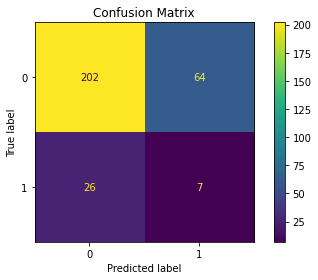

In [ ]:
acc_none = trainNetwork(Xtrain,Xval,Xtest,ytrain,yval,ytest,'None')
accuracy.append(acc_none)
f.append(xcols)

# Using Feature Selection

## Tree-Based Feature Selection
### We rank features based on the computed feature importance, and select the features to keep based on the "elbow in the graph" method. In other words, only take the features before the elbow in the graph. 

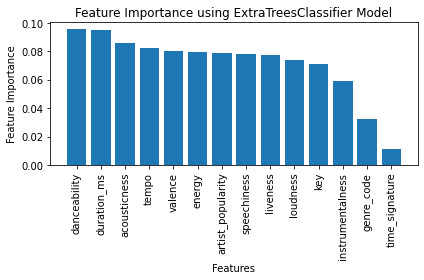

In [ ]:
etc_model = ExtraTreesClassifier(n_estimators=50)
etc_model = etc_model.fit(Xtrain, ytrain)
xcols_ = [x for _, x in sorted(zip(list(etc_model.feature_importances_), xcols),reverse = True)]
plt.bar(xcols_,sorted(list(etc_model.feature_importances_),reverse = True))

plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance using ExtraTreesClassifier Model')
plt.tight_layout()
plt.savefig(path+'figures/TreeFeatSelect')
plt.show()


Model: "billboardModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 84,801
Trainable params: 84,801
Non-trainable params: 0
_________________________________________________________________
10/10 - 0s
Accuracy: 73.57859531772574


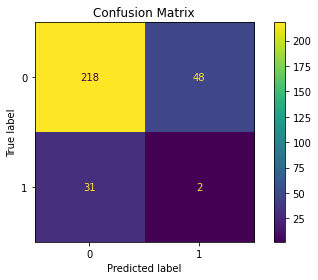

In [ ]:
model_tree = SelectFromModel(etc_model, prefit=True)
feature_idx = model_tree.get_support()
f.append([b for a, b in zip(feature_idx, xcols) if a])

Xtrain_tree = model_tree.transform(Xtrain)
Xval_tree = model_tree.transform(Xval)
Xtest_tree = model_tree.transform(Xtest)

acc_tree = trainNetwork(Xtrain_tree,Xval_tree,Xtest_tree,ytrain,yval,ytest,'Tree')
accuracy.append(acc_tree)

##  L1-based Feature Selection
### Here we use linear models (Lasso and SVM) and only use the features with nonzero coefficients 

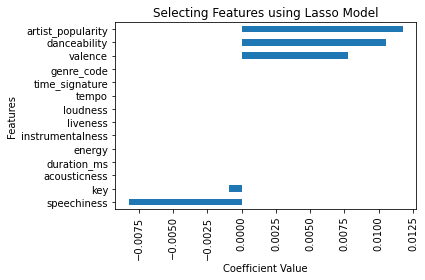

In [ ]:
lasso_model = LassoCV()
lasso_model.fit(Xtrain, ytrain)
coef1 = pd.Series(lasso_model.coef_, index = xcols)
coef1.sort_values().plot(kind = "barh")
plt.title("Selecting Features using Lasso Model")
plt.ylabel("Features")
plt.xlabel('Coefficient Value')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig(path+'figures/LassoFeatSelect')
plt.show()

Model: "billboardModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 400)               2400      
_________________________________________________________________
dense_7 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 82,801
Trainable params: 82,801
Non-trainable params: 0
_________________________________________________________________
10/10 - 0s
Accuracy: 55.18394648829431


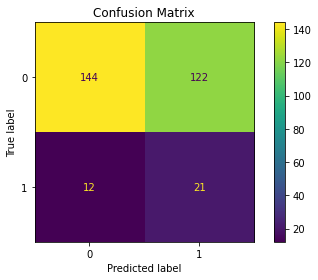

In [ ]:
model_lasso = SelectFromModel(lasso_model, prefit=True)
Xtrain_lasso = model_lasso.transform(Xtrain)
Xval_lasso = model_lasso.transform(Xval)
Xtest_lasso = model_lasso.transform(Xtest)
acc_lasso = trainNetwork(Xtrain_lasso,Xval_lasso,Xtest_lasso,ytrain,yval,ytest,'Lasso')
accuracy.append(acc_lasso)

feature_idx = model_lasso.get_support()
f.append([b for a, b in zip(feature_idx, xcols) if a])



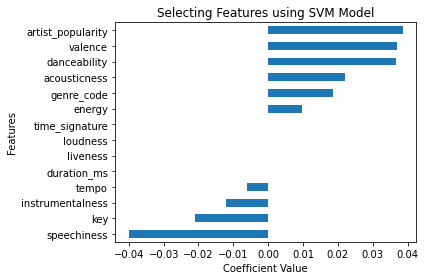

In [ ]:
lsvc = LinearSVC(C=0.15, penalty="l1", dual=False).fit(Xtrain, ytrain)

model = SelectFromModel(lsvc, prefit=True)

coef2 = pd.Series(lsvc.coef_[0], index = xcols)
coef2.sort_values().plot(kind = "barh")
plt.title("Selecting Features using SVM Model")
plt.ylabel("Features")
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.savefig(path + 'figures/SVMFeatSelect')
plt.show()



Model: "billboardModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_10 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 84,801
Trainable params: 84,801
Non-trainable params: 0
_________________________________________________________________
10/10 - 0s
Accuracy: 74.5819397993311


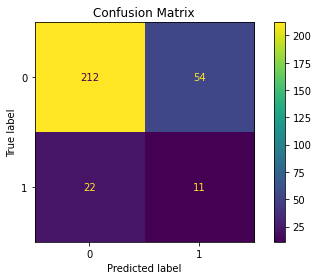

In [ ]:
Xtrain_svm = model.transform(Xtrain)

Xval_svm = model.transform(Xval)
Xtest_svm  = model.transform(Xtest)
acc_svm = trainNetwork(Xtrain_svm,Xval_svm,Xtest_svm,ytrain,yval,ytest,'SVM')
accuracy.append(acc_svm)

feature_idx = model.get_support()
f.append([b for a, b in zip(feature_idx, xcols) if a])


In [ ]:
results["Features"] = f
results["NumFeatures"] = [len(f_) for f_ in f]
results["Accuracy"] = accuracy 

In [ ]:
results

,Method,Features,NumFeatures,Accuracy
0,None,"[acousticness, danceability, duration_ms, ener...",14,69.899666
1,ExtraTrees,"[acousticness, danceability, duration_ms, ener...",10,73.578595
2,Lasso,"[danceability, key, speechiness, valence, arti...",5,55.183946
3,SVM,"[acousticness, danceability, energy, instrumen...",10,74.581940


In [ ]:
from collections import Counter
featCount = Counter()
for fs in f:
  for item in fs:
    featCount[item]+=1

featCount.most_common()

[('danceability', 4),
 ('speechiness', 4),
 ('valence', 4),
 ('artist_popularity', 4),
 ('acousticness', 3),
 ('energy', 3),
 ('key', 3),
 ('tempo', 3),
 ('duration_ms', 2),
 ('instrumentalness', 2),
 ('liveness', 2),
 ('loudness', 2),
 ('genre_code', 2),
 ('time_signature', 1)]